In [1]:
mode = "LS" # LS or IS (latent/image)
cond_mode = "syn" # real, syn
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:


import numpy as np
from sklearn import metrics
utils_path = os.path.abspath(os.path.join('../../'))
if utils_path not in sys.path:
    sys.path.append(utils_path)
from utils.notebookutils import SimaseUSLatentDataset,SimaseUSVideoDataset, SiameseNetwork, model_forward_to_corrcoeff,model_forward_to_pred, model_forward_to_bin_pred, model_forward_to_corr_coeff
from torchvision.transforms import Compose
from einops import rearrange
from functools import partial
import torch
import json

normalization =lambda x: (x  - x.min())/(x.max() - x.min()) * 2 - 1  # should be -1 to 1 due to way we trained the model


ending = "avi" if mode == "IS" else "pt"
dss = tuple()
for name in ("dynamic", "ped_a4c", "ped_psax"):
    latent_vids_basepath = f"/vol/ideadata/at70emic/projects/EchoNet-Synthetic/samples/lvdm_{name}_{cond_mode}/"
    transformations = normalization
    if mode == "IS":
        klass = SimaseUSVideoDataset
    else: 
        klass = SimaseUSLatentDataset

    if mode == "LS": 
        rearranger = partial(rearrange, pattern="c l h w -> l c h w")
        transformations = Compose([normalization, rearranger])

    ds_syn_dynamic = klass(phase="training", transform=transformations, latents_csv=os.path.join(os.path.dirname(latent_vids_basepath), "FileList.csv"), training_latents_base_path=os.path.join(latent_vids_basepath,ending), in_memory=False, generator_seed=0),
    dss += ds_syn_dynamic
ds_syn_dynamic, ds_syn_a4c, ds_syn_psax  = dss

# testdatasets
if mode == "LS": 
    ds_test_dynamic = SimaseUSLatentDataset(phase="testing", transform=normalization, latents_csv="/vol/ideadata/at70emic/projects/TMI23/data/diffusion/dynamic/FileList.csv", training_latents_base_path="/vol/ideadata/at70emic/projects/TMI23/data/diffusion/dynamic/Latents", in_memory=False, generator_seed=0)
    ds_test_psax = SimaseUSLatentDataset(phase="testing", transform=normalization, latents_csv= "/vol/ideadata/at70emic/projects/TMI23/data/diffusion/PSAX/FileList.csv", training_latents_base_path= "/vol/ideadata/at70emic/projects/TMI23/data/diffusion/PSAX/Latents", in_memory=False, generator_seed=0)
    ds_test_a4c = SimaseUSLatentDataset(phase="testing", transform=normalization, latents_csv="/vol/ideadata/at70emic/projects/TMI23/data/diffusion/A4C/FileList.csv", training_latents_base_path= "/vol/ideadata/at70emic/projects/TMI23/data/diffusion/A4C/Latents", in_memory=False, generator_seed=0)
else: 
    ds_test_dynamic = SimaseUSVideoDataset(phase="testing", transform=normalization, latents_csv="/vol/ideadata/at70emic/datasets/EchoNet-Dynamic/FileList.csv", training_latents_base_path= "/vol/ideadata/at70emic/datasets/EchoNet-Dynamic/Videos", in_memory=False, generator_seed=0)
    ds_test_psax = SimaseUSVideoDataset(phase="testing", transform=normalization, latents_csv= "/vol/ideadata/at70emic/datasets/Echonet-Peds/PSAX/processed/FileList.csv", training_latents_base_path= "/vol/ideadata/at70emic/datasets/Echonet-Peds/PSAX/processed/Videos", in_memory=False, generator_seed=0)
    ds_test_a4c = SimaseUSVideoDataset(phase="testing", transform=normalization, latents_csv="/vol/ideadata/at70emic/datasets/Echonet-Peds/A4C/processed/FileList.csv", training_latents_base_path= "/vol/ideadata/at70emic/datasets/Echonet-Peds/A4C/processed/Videos", in_memory=False, generator_seed=0)

datasets_test = {"d": ds_test_dynamic, "p": ds_test_psax, "a": ds_test_a4c}
datasets_syn = {"d": ds_syn_dynamic, "p": ds_syn_psax, "a": ds_syn_a4c}
ds_name_to_name = {"d": "Dynamic", "p": "PSAX", "a": "A4C"}

#load models
models = {"a": None, "d": None, "p": None}
for model_name, model_ending in zip(["a", "d", "p"], ["a4c", "Dynamic", "psax"]): 
    model_basepath = f"/vol/ideadata/ed52egek/pycharm/privatis_us/archive/{model_ending}{mode}Best"
    with open(os.path.join(model_basepath, "config.json")) as config:
        config = config.read()

    # parse config
    config = json.loads(config)
    net = SiameseNetwork(network=config['siamese_architecture'], in_channels=config['n_channels'], n_features=config['n_features'])
    net.eval()
    net = net.cuda()
    best_name = [x for x in os.listdir(model_basepath) if x.endswith("best_network.pth")][0]
    net.load_state_dict(torch.load(os.path.join(model_basepath, best_name)))
    models[model_name] = net

/vol/ideadata/ed52egek/conda/latecho/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set training dataset seed to 0
Set training dataset seed to 0
Set training dataset seed to 0
Set testing dataset seed to 0
Set testing dataset seed to 0
Set testing dataset seed to 0


/vol/ideadata/ed52egek/conda/latecho/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/vol/ideadata/ed52egek/conda/latecho/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



# Confusion Matrices 

Dataset: Dynamic


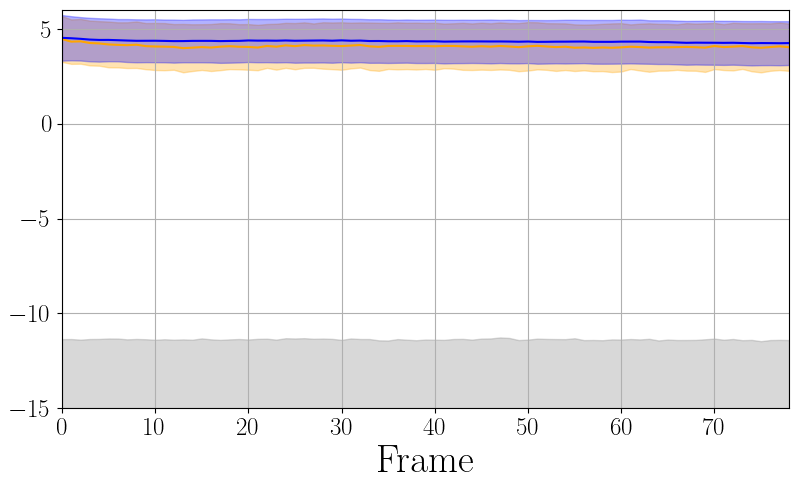

Dataset: A4C


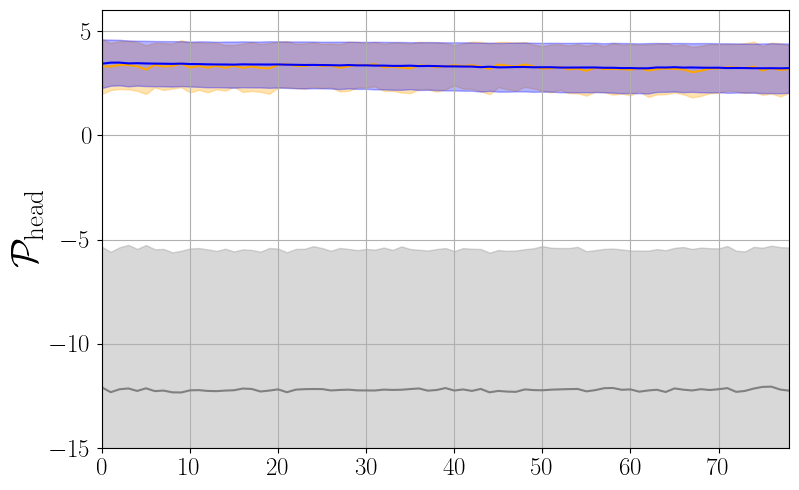

Dataset: PSAX


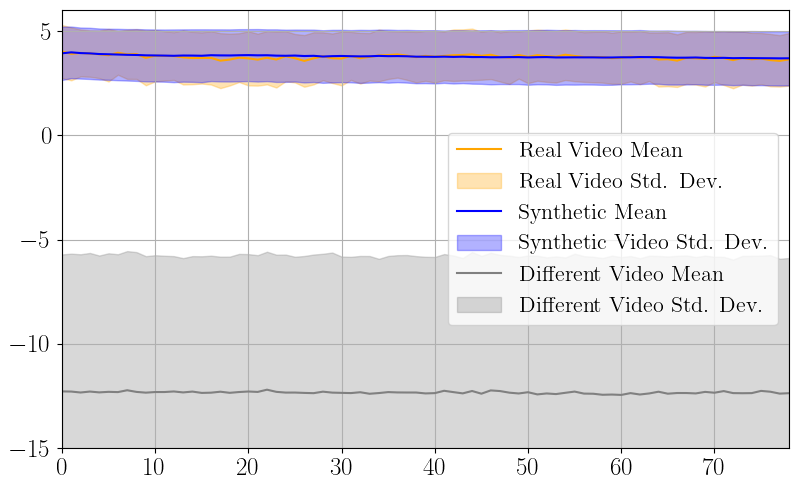

In [35]:
### Now all at once
import torch
import torch.nn as nn
from einops import repeat 
import matplotlib.pyplot as plt



# Number of videos to process for synthetic and real videos
num_videos = 21000
video_length = 80 #210 videos >= 80 frames
bs = 256
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})

#PRED_FUNCITON = "corr"
PRED_FUNCITON = "model_head"
pred_name = {"model_head":"head", "corr":"corr"} # for plot P_{text{...}}

syn_vid_indices = torch.arange(100000)[torch.randperm(100000).int()].int()
syn_vid_indices = [int(x) for x in syn_vid_indices]

for ds in ("d", "a", "p"):
    print("="*80)
    print(f"Dataset: {ds_name_to_name[ds]}")
    synth_cnt = 0
    real_cnt = 0
    diff_cnt = 0

    ds_syn = datasets_syn[ds]
    ds_test = datasets_test[ds]
    model = models[ds]

    def get_prediction(features, ref_frame):
        if PRED_FUNCITON == "model_head": 
            comp_to_frames = torch.cat([features[:ref_frame], features[ref_frame+1:]])
            ref_frame = repeat(features[ref_frame], "c -> b c", b=len(comp_to_frames))
            with torch.no_grad():
                pred = model.prediction_head_forward(ref_frame, comp_to_frames).cpu().squeeze()
        elif PRED_FUNCITON == "corr": 
            train_val_corr_orig = torch.corrcoef(torch.cat([features])).cpu()
            pred = torch.tensor(np.delete(train_val_corr_orig[ref_frame], ref_frame))
        return pred


    ref_frame = 0  

    real_cor_timeseries = []
    # Plotting synthetic videos
    j = 0
    while real_cnt < num_videos and j < len(ds_test):
        latent_real_video = ds_test[j]
        j+=1
        if len(latent_real_video) < video_length:
            continue

        latent_real_video = latent_real_video[:video_length]
        feature_real = []
        with torch.no_grad():
            for i in np.arange(0, len(latent_real_video), bs):
                batch = latent_real_video[i:i+bs].cuda()
                feature_real.append(model.forward_once(batch))
        feature_real = torch.cat(feature_real)
        real_cor_timeseries.append(get_prediction(feature_real, ref_frame))
        real_cnt += 1
    if len(real_cor_timeseries) < num_videos:  
        print(f"Warning: only {len(real_cor_timeseries)} real videos found for {ds_name_to_name[ds]}")

    synth_cor_timeseries = []

    # Plotting synthetic videos
    j = 0
    while synth_cnt < num_videos:
        latent_syn_video = ds_syn[syn_vid_indices[j]]
        j+=1
        if len(latent_syn_video) < video_length:
            continue

        latent_syn_video = latent_syn_video[:video_length]
        feature_synth = []
        with torch.no_grad():
            for i in np.arange(0, len(latent_syn_video), bs):
                batch = latent_syn_video[i:i+bs].cuda()
                feature_synth.append(model.forward_once(batch))
        feature_synth = torch.cat(feature_synth)

        synth_cor_timeseries.append(get_prediction(feature_synth, ref_frame))
        synth_cnt += 1

    synth_cor_timeseries_diff = []
    # Plotting synthetic videos
    j = 0
    while diff_cnt < len(real_cor_timeseries):
        latent_syn_video = ds_syn[j]
        j+=1
        if len(latent_syn_video) < video_length:
            continue

        latent_syn_ref = ds_syn[(j+1)%len(ds_syn)]
        latent_syn_video = latent_syn_video[:video_length]
        latent_syn_video[ref_frame] = latent_syn_ref[ref_frame] 
        feature_synth_diff = []
        with torch.no_grad():
            for i in np.arange(0, len(latent_syn_video), bs):
                batch = latent_syn_video[i:i+bs].cuda()
                feature_synth_diff.append(model.forward_once(batch))
        feature_synth_diff = torch.cat(feature_synth_diff)
    
        synth_cor_timeseries_diff.append(get_prediction(feature_synth_diff, ref_frame))
        diff_cnt += 1

    synth_cor_timeseries = np.array(synth_cor_timeseries)
    real_cor_timeseries = np.array(real_cor_timeseries)
    synth_cor_timeseries_diff = np.array(synth_cor_timeseries_diff)

    # Compute mean and standard deviation
    synth_mean = np.mean(synth_cor_timeseries, axis=0)
    synth_std = np.std(synth_cor_timeseries, axis=0)

    real_mean = np.mean(real_cor_timeseries, axis=0)
    real_std = np.std(real_cor_timeseries, axis=0)

    diff_mean = np.mean(synth_cor_timeseries_diff, axis=0)
    diff_std = np.std(synth_cor_timeseries_diff, axis=0)


    # Time axis (assuming all time series are of the same length)
    time_axis = np.arange(real_mean.shape[0])

    # Create the plot
    fig, ax = plt.subplots(figsize=(5*1.618, 5))
    # Plot the real data
    ax.plot(time_axis, real_mean, label=r'Real Video Mean', color='orange')
    ax.fill_between(time_axis, real_mean - real_std, real_mean + real_std, color='orange', alpha=0.3, label=r'Real Video Std. Dev.')

    # Plot the synthetic data
    ax.plot(time_axis, synth_mean, label=r'Synthetic Mean', color='blue')
    ax.fill_between(time_axis, synth_mean - synth_std, synth_mean + synth_std, color='blue', alpha=0.3, label=r'Synthetic Video Std. Dev.')

    # Plot diff data
    ax.plot(time_axis, diff_mean, label=r'Different Video Mean', color='grey')
    ax.fill_between(time_axis, diff_mean - diff_std, diff_mean + diff_std, color='grey', alpha=0.3, label=r'Different Video Std. Dev.')

    # Customize the plot
    #ax.set_title('Mean Correlation Coefficient')
    ax.set_xlabel('Frame', fontsize=28)
    ax.set_ylabel(r'$\mathcal{P}_{\text{' + str(pred_name[PRED_FUNCITON]) + r'}}$', fontsize=28)


    if PRED_FUNCITON == "corr": 
        ax.set_ylim(-1, 1)
    else: 
        ax.set_ylim(-15, 6)
        #pass

    ax.set_xlim(0, video_length -2)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=18)
    if ds == "p":
        ax.legend(fontsize=16)

    if ds != "d": 
        plt.gca().xaxis.label.set_visible(False)
    if ds != "a": 
        plt.gca().yaxis.label.set_visible(False)

    plt.tight_layout()
    plt.savefig(f"tempcons_{pred_name[PRED_FUNCITON]}_rvssvsd_{ds_name_to_name[ds]}_space{mode}_cond{cond_mode}.pdf", dpi=600)
    plt.show()

In [4]:
raise ValueError

ValueError: 

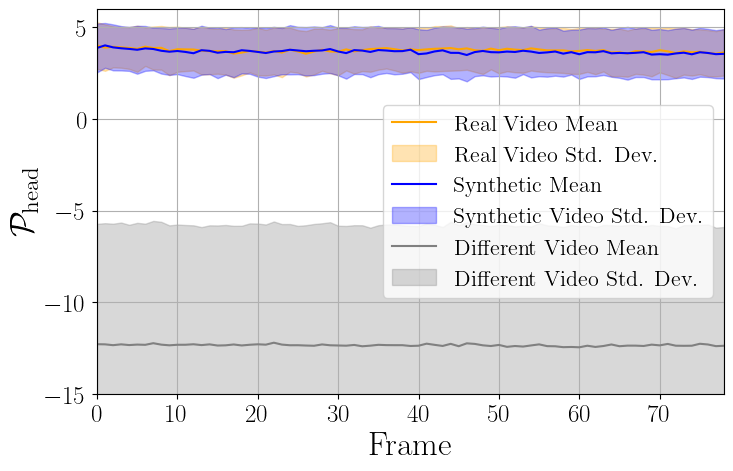

In [21]:
fig, ax = plt.subplots(figsize=(5*1.618, 5))
# Plot the real data
ax.plot(time_axis, real_mean, label=r'Real Video Mean', color='orange')
ax.fill_between(time_axis, real_mean - real_std, real_mean + real_std, color='orange', alpha=0.3, label=r'Real Video Std. Dev.')

# Plot the synthetic data
ax.plot(time_axis, synth_mean, label=r'Synthetic Mean', color='blue')
ax.fill_between(time_axis, synth_mean - synth_std, synth_mean + synth_std, color='blue', alpha=0.3, label=r'Synthetic Video Std. Dev.')

# Plot diff data
ax.plot(time_axis, diff_mean, label=r'Different Video Mean', color='grey')
ax.fill_between(time_axis, diff_mean - diff_std, diff_mean + diff_std, color='grey', alpha=0.3, label=r'Different Video Std. Dev.')

# Customize the plot
#ax.set_title('Mean Correlation Coefficient')
ax.set_ylabel(r'$\mathcal{P}_{\text{' + str(pred_name[PRED_FUNCITON]) + r'}}$', fontsize=24)
ax.set_xlabel('Frame', fontsize=24)
if PRED_FUNCITON == "corr": 
    ax.set_ylim(-1, 1)
else: 
    ax.set_ylim(-15, 6)
    #pass

ax.set_xlim(0, video_length -2)
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(fontsize=16)
plt.savefig(f"tempcons_{pred_name[PRED_FUNCITON]}_rvssvsd_{ds_name_to_name[ds]}_space{mode}_cond{cond_mode}.pdf", dpi=600)
plt.show()

In [ ]:
import torch
import torch.nn as nn
from einops import repeat 



# Number of videos to process for synthetic and real videos
num_videos = 1000
synth_cnt = 0
real_cnt = 0
diff_cnt = 0
video_length = 112
bs = 256
ds = "d"


ds_syn = datasets_syn[ds]
ds_test = datasets_test[ds]
model = models[ds]

PRED_FUNCITON = "model_head"
pred_name = {"model_head":"head"} # for plot P_{text{...}}
def get_prediction(features, ref_frame):
    if PRED_FUNCITON == "model_head": 
        comp_to_frames = torch.cat([features[:ref_frame], features[ref_frame+1:]])
        ref_frame = repeat(features[ref_frame], "c -> b c", b=len(comp_to_frames))
        with torch.no_grad():
            pred = model.prediction_head_forward(ref_frame, comp_to_frames).cpu().squeeze()
    #train_val_corr_orig = torch.corrcoef(torch.cat([feature_real])).cpu()
    #train_val_corr_frame = np.delete(train_val_corr_orig[ref_frame], ref_frame)
    #real_cor_timeseries.append(train_val_corr_frame)
    return pred


ref_frame = 0  

real_cor_timeseries = []
# Plotting synthetic videos
j = 0
while real_cnt < num_videos:
    latent_real_video = ds_test[j]
    j+=1
    if len(latent_real_video) < video_length:
        continue

    latent_real_video = latent_real_video[:video_length]
    feature_real = []
    with torch.no_grad():
        for i in np.arange(0, len(latent_real_video), bs):
            batch = latent_real_video[i:i+bs].cuda()
            feature_real.append(model.forward_once(batch))
    feature_real = torch.cat(feature_real)
    real_cor_timeseries.append(get_prediction(feature_real, ref_frame))
    real_cnt += 1


synth_cor_timeseries = []

# Plotting synthetic videos
j = 0
while synth_cnt < num_videos:
    latent_syn_video = ds_syn[j]
    j+=1
    if len(latent_syn_video) < video_length:
        continue

    latent_syn_video = latent_syn_video[:video_length]
    feature_synth = []
    with torch.no_grad():
        for i in np.arange(0, len(latent_syn_video), bs):
            batch = latent_syn_video[i:i+bs].cuda()
            feature_synth.append(model.forward_once(batch))
    feature_synth = torch.cat(feature_synth)

    synth_cor_timeseries.append(get_prediction(feature_synth, ref_frame))
    synth_cnt += 1

synth_cor_timeseries_diff = []
# Plotting synthetic videos
j = 0
while diff_cnt < num_videos:
    latent_syn_video = ds_syn[j]
    j+=1
    if len(latent_syn_video) < video_length:
        continue
    latent_syn_ref = ds_syn[(j+1)%len(ds_syn)]
    latent_syn_video = latent_syn_video[:video_length]
    latent_syn_video[ref_frame] = latent_syn_ref[ref_frame] 
    feature_synth_diff = []
    with torch.no_grad():
        for i in np.arange(0, len(latent_syn_video), bs):
            batch = latent_syn_video[i:i+bs].cuda()
            feature_synth_diff.append(model.forward_once(batch))
    feature_synth_diff = torch.cat(feature_synth_diff)
   
    synth_cor_timeseries_diff.append(get_prediction(feature_synth_diff, ref_frame))
    diff_cnt += 1

synth_cor_timeseries = np.array(synth_cor_timeseries)
real_cor_timeseries = np.array(real_cor_timeseries)
synth_cor_timeseries_diff = np.array(synth_cor_timeseries_diff)

# Compute mean and standard deviation
synth_mean = np.mean(synth_cor_timeseries, axis=0)
synth_std = np.std(synth_cor_timeseries, axis=0)

real_mean = np.mean(real_cor_timeseries, axis=0)
real_std = np.std(real_cor_timeseries, axis=0)

diff_mean = np.mean(synth_cor_timeseries_diff, axis=0)
diff_std = np.std(synth_cor_timeseries_diff, axis=0)


SyntaxError: expected ':' (273905437.py, line 29)

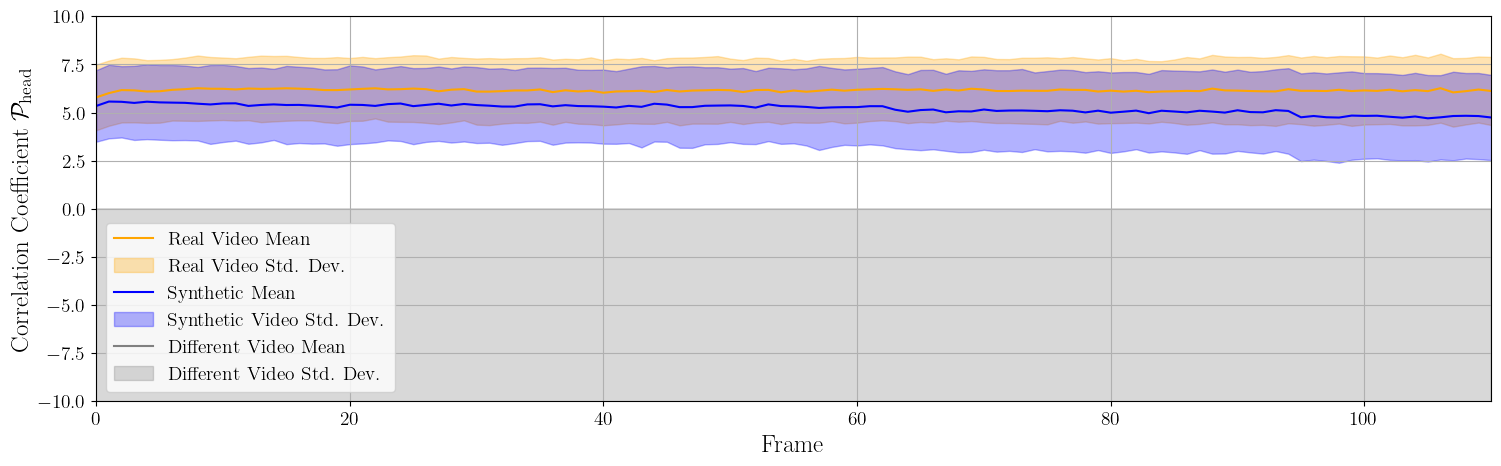

In [ ]:

import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})

# Time axis (assuming all time series are of the same length)
time_axis = np.arange(real_mean.shape[0])

# Create the plot
fig, ax = plt.subplots(figsize=(18, 5))
# Plot the real data
ax.plot(time_axis, real_mean, label=r'Real Video Mean', color='orange')
ax.fill_between(time_axis, real_mean - real_std, real_mean + real_std, color='orange', alpha=0.3, label=r'Real Video Std. Dev.')

# Plot the synthetic data
ax.plot(time_axis, synth_mean, label=r'Synthetic Mean', color='blue')
ax.fill_between(time_axis, synth_mean - synth_std, synth_mean + synth_std, color='blue', alpha=0.3, label=r'Synthetic Video Std. Dev.')

# Plot diff data
ax.plot(time_axis, diff_mean, label=r'Different Video Mean', color='grey')
ax.fill_between(time_axis, diff_mean - diff_mean, diff_mean + diff_mean, color='grey', alpha=0.3, label=r'Different Video Std. Dev.')

# Customize the plot
#ax.set_title('Mean Correlation Coefficient')
ax.set_ylabel(r'Correlation Coefficient $\mathcal{P}_{\text{' + str(pred_name) + r'}}$', fontsize=18)
ax.set_xlabel('Frame', fontsize=18)
ax.set_ylim(-10, 10)
ax.set_xlim(0, video_length -2)
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
plt.savefig(f"tempcons_{pred_name}_rvssvsd_{ds_name_to_name[ds]}_space{mode}.pdf", dpi=600)
plt.show()